In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML DATASET/cleaned_retail_data.csv',
                 low_memory=False,
                 parse_dates=['Clean_Date'])

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,Clean_Date,Price,Customer_ID,Country,Total_Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.9500,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.7500,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.7500,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7 SINGLE SIZE """,48.0,2009-12-01 07:45:00,2.1000,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.2500,13085.0,United Kingdom,30.0


In [ ]:
print(f"Total Rows: {len(df)}")
df.head()

Total Rows: 805620


,Invoice,StockCode,Description,Quantity,Clean_Date,Price,Customer_ID,Country,Total_Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.9500,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.7500,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.7500,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7 SINGLE SIZE """,48.0,2009-12-01 07:45:00,2.1000,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.2500,13085.0,United Kingdom,30.0


In [ ]:
# Convert our clean date column to a real date format
df['Clean_Date'] = pd.to_datetime(df['Clean_Date'], errors='coerce')

In [ ]:
df = df.dropna(subset=['Clean_Date'])

In [ ]:
# 3. Create a snapshot date (one day after the last sale)
snapshot_date = df['Clean_Date'].max() + pd.Timedelta(days=1)

In [ ]:
print(f"Data is ready! We have {len(df)} clean rows to analyze.")

Data is ready! We have 805611 clean rows to analyze.


# **Breaking Down RFM**

---



# R — Recency (How recent?)
Definition: The number of days since the customer’s last purchase.



Logic: A customer who bought something yesterday is much more likely to buy again than someone who hasn't visited in a year.

Goal: Identify customers who are starting to "drift away" (Churn Risk) so you can win them back.

# F — Frequency (How often?)
Definition: How many unique orders the customer has placed over a specific time.

Logic: This shows loyalty. A customer with a high frequency is a "regular" who trusts the brand.
+1

Goal: Distinguish between one-time shoppers and loyal fans.

# M — Monetary (How much?)
Definition: The total amount of money the customer has spent.

Logic: This helps you find your "Big Spenders." You handled those massive 74,215 quantity orders in MySQL specifically to make sure this number is accurate.

Goal: Identify the customers who contribute the most to the company's revenue.

In [ ]:
# Create the RFM summary table
rfm = df.groupby('Customer_ID').agg({
    # 1. Recency: How many days from their last order to our 'snapshot'
    'Clean_Date': lambda x: (snapshot_date - x.max()).days,

    # 2. Frequency: How many unique invoices did they have?
    'Invoice': 'nunique',

    # 3. Monetary: The total sum of their sales
    'Total_Sales': 'sum'
})

In [ ]:
# Rename the columns so they look professional
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [ ]:
# Keep only customers who spent more than $0
rfm = rfm[rfm['Monetary'] > 0]

In [ ]:
rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


NOTE :pd.qcut: This is like a "Slicer." It takes all your customers and puts the top 25% in the "4" group, the next 25% in "3," and so on.

In [ ]:
# 1. Give a Grade for Recency (R)
# Lower days is BETTER, so we give a '4' to the lowest days.
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

In [ ]:
# 2. Give a Grade for Frequency (F)
# More orders is BETTER, so we give a '4' to the highest count.
# We use .rank(method='first') to handle customers with the same number of orders.
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

In [ ]:
# 3. Give a Grade for Monetary (M)
# More money spent is BETTER, so we give a '4' to the biggest spenders.
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# **The Grades (1 to 4):**

**Score 4:** Your "A" customers. These are the people buying recently, buying often, and spending a lot.


**Score 1:** Your "At Risk" customers. These people haven't bought in a long time and didn't spend much.

**RFM_Total:** We add the three scores together. The highest possible total is 12 (4+4+4), and the lowest is 3 (1+1+1).

In [ ]:
# 4. Create a combined RFM Score (Sum of all three)
rfm['RFM_Total'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Total
Customer_ID,,,,,,,
12346.0,326,12,77556.46,2,4,4,10
12347.0,2,8,5633.32,4,4,4,12
12348.0,75,5,2019.40,3,3,3,9
12349.0,19,4,4428.69,4,3,4,11
12350.0,310,1,334.40,2,1,1,4


In [ ]:
# Define a function to name our segments based on the Total Score
def segment_me(score):
    if score >= 10:
        return 'Champions'        # Your best, most loyal customers
    elif score >= 7:
        return 'Loyal'            # Good customers who buy regularly
    elif score >= 5:
        return 'At Risk'          # Used to buy, but starting to fade away
    else:
        return 'Lost'             # Haven't bought in a long time

In [ ]:
# Apply the names to your RFM table
rfm['Customer_Segment'] = rfm['RFM_Total'].apply(segment_me)

In [ ]:
#  Count how many customers are in each group
print(rfm['Customer_Segment'].value_counts())

Customer_Segment
Loyal        1781
Champions    1738
At Risk      1212
Lost         1147
Name: count, dtype: int64


In [ ]:
#View the final result
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Total,Customer_Segment
Customer_ID,,,,,,,,
12346.0,326,12,77556.46,2,4,4,10,Champions
12347.0,2,8,5633.32,4,4,4,12,Champions
12348.0,75,5,2019.40,3,3,3,9,Loyal
12349.0,19,4,4428.69,4,3,4,11,Champions
12350.0,310,1,334.40,2,1,1,4,Lost


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#  Set the style
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

<Figure size 1000x600 with 0 Axes>

In [ ]:
segment_counts = rfm['Customer_Segment'].value_counts()

Text(0.5, 1.0, 'Customer Segmentation Distribution')

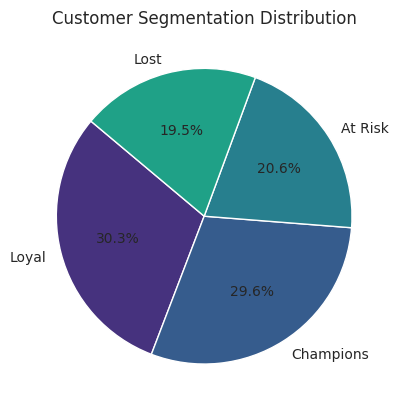

In [ ]:
#Create the Pie Chart
plt.pie(segment_counts,
        labels=segment_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('viridis'))

plt.title('Customer Segmentation Distribution')

In [ ]:
# Get the country for each customer from the original dataframe
customer_countries = df.groupby('Customer_ID')['Country'].first()

# Add the country to our RFM segmentation table
rfm_with_country = rfm.join(customer_countries)

# Find which countries have the most "Champions"
champions_by_country = rfm_with_country[rfm_with_country['Customer_Segment'] == 'Champions']
print(champions_by_country['Country'].value_counts().head(10))

Country
United Kingdom    1577
Germany             39
France              33
Spain               10
Belgium              9
Italy                7
Denmark              6
Switzerland          6
Norway               6
Portugal             5
Name: count, dtype: int64


In [ ]:
# Calculate total monetary value for the 'At Risk' segment
at_risk_revenue = rfm[rfm['Customer_Segment'] == 'At Risk']['Monetary'].sum()

print(f"Total Revenue currently At Risk: ${at_risk_revenue:,.2f}")

Total Revenue currently At Risk: $670,178.27


In [ ]:
# Get the IDs of your Champions
champion_ids = rfm[rfm['Customer_Segment'] == 'Champions'].index

# ilter original data for only these customers
champion_data = df[df['Customer_ID'].isin(champion_ids)]

# Find the most popular items
top_items = champion_data['Description'].value_counts().head(10)

print("Top 10 Products Bought by Champions:")
print(top_items)

Top 10 Products Bought by Champions:
Description
WHITE HANGING HEART T-LIGHT HOLDER    3779
REGENCY CAKESTAND 3 TIER              2614
JUMBO BAG RED RETROSPOT               2240
ASSORTED COLOUR BIRD ORNAMENT         2004
LUNCH BAG  BLACK SKULL.               1723
PARTY BUNTING                         1645
LUNCH BAG SPACEBOY DESIGN             1539
LUNCH BAG CARS BLUE                   1501
WOODEN FRAME ANTIQUE WHITE            1484
HOME BUILDING BLOCK WORD              1464
Name: count, dtype: int64


In [ ]:
# Create the 'Churn' label (Target variable)
# 1 = Churned (at risk), 0 = Active
rfm['Churn'] = (rfm['Recency'] > 180).astype(int)

# 2. Check the balance
print(rfm['Churn'].value_counts())

Churn
0    3478
1    2400
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Select our "Predictors" (Frequency and Monetary)
X = rfm[['Frequency', 'Monetary']]
y = rfm['Churn']

In [ ]:
# Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and Train the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make Predictions
y_pred = model.predict(X_test)

In [ ]:
print("--- Churn Prediction Report ---")
print(classification_report(y_test, y_pred))

--- Churn Prediction Report ---
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       695
           1       0.54      0.60      0.57       481

    accuracy                           0.63      1176
   macro avg       0.62      0.62      0.62      1176
weighted avg       0.63      0.63      0.63      1176



In [ ]:
# Get feature importance from the model
importances = model.feature_importances_
feature_names = ['Frequency', 'Monetary']

In [ ]:
# Create a small summary
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

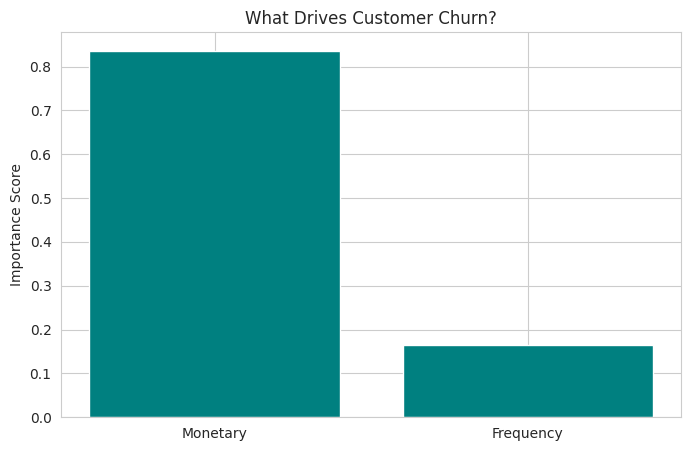

In [ ]:
# Visualize
plt.figure(figsize=(8, 5))
plt.bar(feature_df['Feature'], feature_df['Importance'], color='teal')
plt.title('What Drives Customer Churn?')
plt.ylabel('Importance Score')
plt.show()

In [ ]:
# Calculate the probability for all customers
# [:, 1] takes the probability of them being in the 'Churn' (1) group
rfm['Churn_Probability'] = model.predict_proba(rfm[['Frequency', 'Monetary']])[:, 1]

# View the top 5 customers most likely to leave soon
print(rfm[['Frequency', 'Monetary', 'Churn_Probability']].sort_values(by='Churn_Probability', ascending=False).head())

             Frequency  Monetary  Churn_Probability
Customer_ID                                        
14458.0              1    237.42                1.0
14393.0              1     67.95                1.0
14394.0              1     93.80                1.0
12387.0              1    143.94                1.0
12392.0              1    234.75                1.0


**High Churn Probability (> 80%) :**  Send an immediate "exclusive" discount code.

**Medium Churn Probability (50-80%):** Send a personalized newsletter featuring their "Star Products" (which we identified earlier).

**Low Churn Probability (< 50%):**  Do nothing; keep them in the regular loyalty loop.

In [ ]:
#Define the Action Plan Logic
def business_strategy(row):
    if row['Customer_Segment'] == 'Champions':
        return 'VIP Loyalty Program: Early access to new arrivals & zero discounts.'
    elif row['Customer_Segment'] == 'Loyal':
        return 'Upsell: Recommend high-margin products related to past purchases.'
    elif row['Churn_Probability'] > 0.7:
        return 'Urgent Win-Back: Send a high-value (20-30%) discount coupon.'
    elif row['Customer_Segment'] == 'At Risk':
        return 'Re-engagement: Send "We Miss You" email and store updates.'
    else:
        return 'Standard Monitoring: Keep in regular newsletter loop.'

In [ ]:
#Apply the strategy to each customer
rfm['Marketing_Action'] = rfm.apply(business_strategy, axis=1)

In [ ]:
#View the results for the most at-risk customers
print("Strategy for Customers with Highest Churn Probability:")
print(rfm[['Customer_Segment', 'Churn_Probability', 'Marketing_Action']].sort_values(by='Churn_Probability', ascending=False).head(10))

Strategy for Customers with Highest Churn Probability:
            Customer_Segment  Churn_Probability  \
Customer_ID                                       
14458.0                 Lost                1.0   
14393.0                 Lost                1.0   
14394.0                 Lost                1.0   
12387.0                 Lost                1.0   
12392.0                 Lost                1.0   
14483.0              At Risk                1.0   
14373.0                 Lost                1.0   
14376.0                 Lost                1.0   
14384.0                 Lost                1.0   
14386.0                 Lost                1.0   

                                              Marketing_Action  
Customer_ID                                                     
14458.0      Urgent Win-Back: Send a high-value (20-30%) di...  
14393.0      Urgent Win-Back: Send a high-value (20-30%) di...  
14394.0      Urgent Win-Back: Send a high-value (20-30%) di...  
12387.0

In [ ]:
segment_analysis = rfm.groupby('Customer_Segment').agg(
    Total_Monetary=('Monetary', 'sum'),
    Average_Monetary=('Monetary', 'mean'),
    Average_Recency=('Recency', 'mean'),
    Customer_Count=('Monetary', 'count')
)

# Format for the report
print("Executive Summary: Revenue by Segment")
print(segment_analysis)

Executive Summary: Revenue by Segment
                  Total_Monetary  Average_Monetary  Average_Recency  \
Customer_Segment                                                      
At Risk             6.701783e+05        552.952369       264.070132   
Champions           1.432873e+07       8244.380731        37.986191   
Lost                2.614016e+05        227.900271       473.395815   
Loyal               2.483071e+06       1394.200638       142.824818   

                  Customer_Count  
Customer_Segment                  
At Risk                     1212  
Champions                   1738  
Lost                        1147  
Loyal                       1781  


In [ ]:
# Compare different churn definitions
churn_90 = (rfm['Recency'] > 90).sum()
churn_180 = (rfm['Recency'] > 180).sum()
churn_365 = (rfm['Recency'] > 365).sum()

print(f"Customers 'At Risk' at 90 days: {churn_90}")
print(f"Customers 'At Risk' at 180 days: {churn_180}")
print(f"Customers 'At Risk' at 365 days: {churn_365}")

Customers 'At Risk' at 90 days: 2989
Customers 'At Risk' at 180 days: 2400
Customers 'At Risk' at 365 days: 1609
